# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score

### Training model on complete dataset, i.e., without removing collinear features.

In [2]:
# Loading complete feature data.
dataframe = pd.read_pickle('datasets/final_feature_data.pkl')
# Print first five rows
dataframe.head()

,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,...,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [3]:
# Function to reduce memory of the data frame
def reduce_mem(df):
    
    st_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of the dataframe is :",st_mem_usg,"MB")
    
    for column in df.columns:
        if df[column].dtypes in ["int64", "int32", "int16"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.iinfo(np.int8).min and colMax < np.iinfo(np.int8).max:
                df[column] = df[column].astype(np.int8)
            
            elif colMin > np.iinfo(np.int16).min and colMax < np.iinfo(np.int16).max:
                df[column] = df[column].astype(np.int16)
            
            elif colMin > np.iinfo(np.int32).min and colMax < np.iinfo(np.int32).max:
                df[column] = df[column].astype(np.int32)
        
        if df[column].dtypes in ["float64", "float32"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.finfo(np.float16).min and colMax < np.finfo(np.float16).max:
                df[column] = df[column].astype(np.float16)
            
            elif colMin > np.finfo(np.float32).min and colMax < np.finfo(np.float32).max:
                df[column] = df[column].astype(np.float32)
    
    print("Memory usage total")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage: ",mem_usg," MB")
    print("Size reduced by ",100*mem_usg/st_mem_usg,"%")
    
    return df

In [4]:
dataframe = reduce_mem(dataframe)

Memory usage of the dataframe is : 4380.480062484741 MB
Memory usage total
Memory usage:  1309.2947788238525  MB
Size reduced by  29.88929889298893 %


In [5]:
dataframe['order_diff'] = dataframe.order_number - dataframe.product_last_bought_order
dataframe

,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,...,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,1,196,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,1,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,1,12427,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,1,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,206209,44325,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,206209,48370,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,206209,48697,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [6]:
dataframe.drop(['user_id', 'product_id'], axis= 1, inplace= True)
dataframe

,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [7]:
from sklearn.linear_model import LogisticRegression
log_classifier_bal=LogisticRegression()

In [8]:
from sklearn.model_selection import GridSearchCV
params={'penalty':['l2'], 'C':[4,5,6], 'class_weight': [{0:1, 1:10}], 'max_iter':[1000]}

In [9]:
label = 'reordered'
x_columns = dataframe.columns.drop('reordered')

In [10]:
X = dataframe[x_columns]
y = dataframe[label]

In [11]:
#Stratify parameter is used to make a split so that ratio of values in the sample produced will be same/
#as the ratio of values given to it.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [12]:
classifier_reg_bal=GridSearchCV (log_classifier_bal, params, scoring='accuracy', cv=5)


In [13]:
classifier_reg_bal.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [4, 5, 6], 'class_weight': [{0: 1, 1: 10}],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring='accuracy')

In [14]:
y_pred_bal=classifier_reg_bal.predict(X_test)

In [15]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

preds_log_bal = [1 if i > 0.5 else 0 for i in y_pred_bal]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.93      0.50      0.65   1911460
         1.0       0.13      0.67      0.21    207206

    accuracy                           0.51   2118666
   macro avg       0.53      0.58      0.43   2118666
weighted avg       0.85      0.51      0.61   2118666

Accuracy   Score :  0.514414730778707
F1 Score:  0.21280561568461814


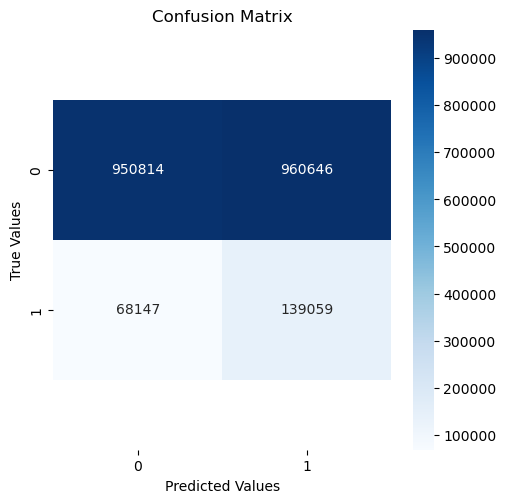

In [16]:
print ("\n Classification report : \n",classification_report (y_test, preds_log_bal))
print ("Accuracy   Score : ",accuracy_score (y_test, preds_log_bal))

#Generate confusion-matrix as below
conf_matrix_log_balanced = confusion_matrix (y_test,preds_log_bal)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix_log_balanced, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1_bal = f1_score (y_test, preds_log_bal)
print("F1 Score: ", f1_bal)

### Training model on updated dataset, i.e., by removing collinear features.

In [17]:
dataframe = pd.read_pickle('datasets/corr_removed_feature_data.pkl')
dataframe.head()

,user_id,product_id,total_orders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,...,days_since_prior_order_std,products_by_user,reorder_rate_by_user,order_size_avg,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667


In [18]:
dataframe=dataframe.sample(frac=.70)
dataframe

,user_id,product_id,total_orders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,...,days_since_prior_order_std,products_by_user,reorder_rate_by_user,order_size_avg,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
1420517,34546,23646,1.0,0.00,3.00,0.00,1.0,0.0,0.0,0.0,...,8.723605,105,0.295238,9.545455,14,4,11,0.500000,0.000000,0.363636
3321112,80628,27796,1.0,0.00,6.00,3.00,13.0,0.0,0.0,0.0,...,2.432017,799,0.829787,10.243590,4,7,12,1.000000,0.714286,0.833333
3451254,83789,31717,4.0,0.75,13.25,7.50,56.0,1.0,0.0,0.0,...,1.777297,764,0.828534,13.642857,15,21,27,1.000000,0.714286,0.814815
181655,4589,3265,1.0,0.00,7.00,15.00,2.0,0.0,0.0,0.0,...,7.456044,28,0.250000,9.333333,8,9,11,0.000000,0.444444,0.272727
5134078,124474,2643,1.0,0.00,11.00,3.00,4.0,0.0,0.0,0.0,...,5.379616,230,0.460870,19.166667,11,15,6,0.545455,0.933333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410512,34252,2832,1.0,0.00,9.00,8.00,14.0,0.0,0.0,0.0,...,5.438468,358,0.631285,9.179487,5,14,17,0.800000,0.785714,0.882353
3106151,75448,15891,1.0,0.00,1.00,15.00,3.0,0.0,0.0,0.0,...,8.521681,7,0.285714,1.750000,2,3,1,0.000000,0.333333,1.000000
1825980,44597,30391,2.0,0.50,13.50,25.50,8.0,1.0,0.0,0.0,...,9.682029,155,0.464516,17.222222,4,27,18,0.250000,0.629630,0.722222
6050176,147096,21009,1.0,0.00,13.00,17.00,8.0,0.0,0.0,0.0,...,11.170553,128,0.328125,16.000000,21,12,14,0.380952,0.500000,0.571429


In [19]:
log_classifier_bal=LogisticRegression()

In [20]:
params={'penalty':['l2'], 'max_iter':[1000], 'class_weight': [{0:1, 1:10}], 'C':[4,5,6]}


In [21]:
label = 'reordered'
x_columns = dataframe.columns.drop('reordered')

In [22]:
X = dataframe[x_columns]
y = dataframe[label]

In [23]:
X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape,y_train.shape)
print (X_test.shape,y_test.shape)

(4449197, 51) (4449197,)
(1483066, 51) (1483066,)


In [24]:
classifier_reg_bal=GridSearchCV (log_classifier_bal, params, scoring='accuracy', cv=5)


In [25]:
classifier_reg_bal.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [4, 5, 6], 'class_weight': [{0: 1, 1: 10}],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring='accuracy')

In [26]:
y_pred_bal=classifier_reg_bal.predict(X_test)

In [29]:
preds_log_bal = [1 if i > 0.5 else 0 for i in y_pred_bal]



 Classification report : 
               precision    recall  f1-score   support

         0.0       0.93      0.46      0.62   1338064
         1.0       0.12      0.70      0.21    145002

    accuracy                           0.48   1483066
   macro avg       0.53      0.58      0.41   1483066
weighted avg       0.86      0.48      0.58   1483066

Accuracy   Score :  0.48370065796127754
F1 Score:  0.2101514904573184


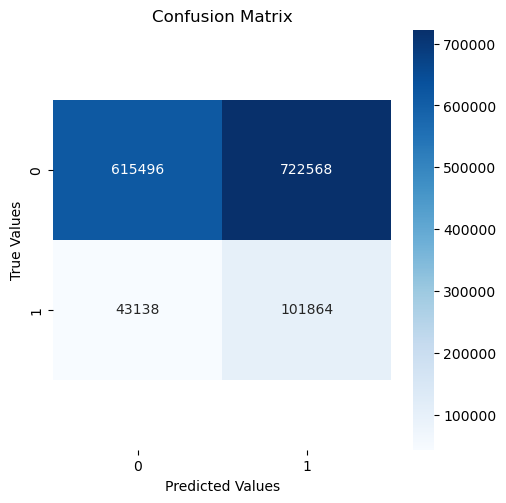

In [30]:
print ("\n Classification report : \n",classification_report (y_test, preds_log_bal))
print ("Accuracy   Score : ",accuracy_score (y_test, preds_log_bal))

#Generate confusion-matrix as below
conf_matrix_log_balanced = confusion_matrix (y_test,preds_log_bal)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix_log_balanced, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1_bal = f1_score (y_test, preds_log_bal)
print ("F1 Score: ", f1_bal)
